Epoch 500, Loss: 0.000181
Epoch 1000, Loss: 0.000076


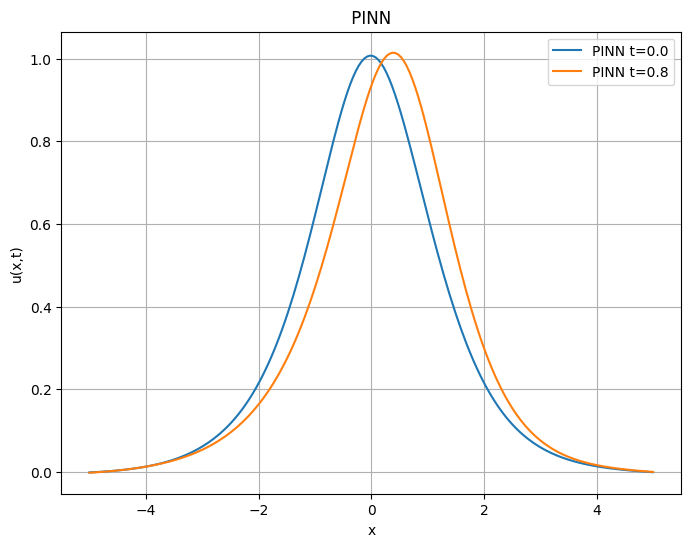

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Crear un DataFrame con los valores de x y las soluciones de la PINN para diferentes tiempos
pinn_data = pd.DataFrame({"x": x_np})

# Agregar la solución para cada tiempo
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    pinn_data[f"u_pinn_t={t}"] = u_pinn.detach().cpu().numpy().flatten()

# Guardar en un archivo CSV
pinn_csv_path = "solution_pinn.csv"
pinn_data.to_csv(pinn_csv_path, index=False)

print(f"Archivo guardado en: {pinn_csv_path}")


Archivo guardado en: solution_pinn.csv


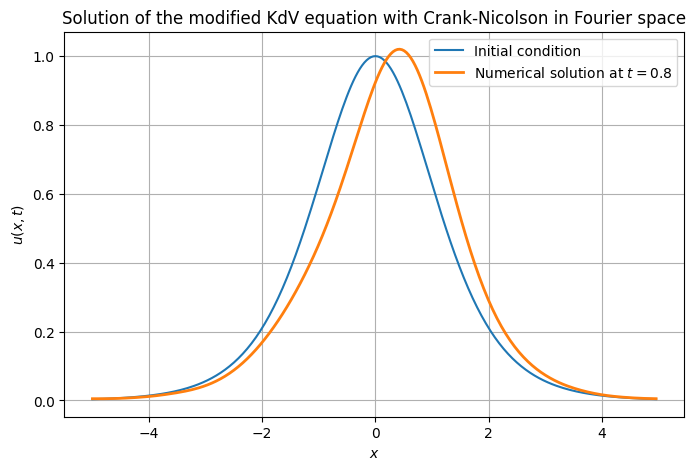

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# This code solves the modified Korteweg–de Vries equation:
# u_t + u * u_x + 0.1 * u_xxx = 0

# Domain parameters
L = 10  # Domain length in x (from -5 to 5)
Nx = 256  # Number of points in x
dx = L / Nx  # Spatial step
x = np.linspace(-5, 5, Nx, endpoint=False)  # Spatial mesh

# Time parameters
T = 0.8  # Total simulation time
dt = 1e-4  # Small time step for stability
Nt = int(T / dt)  # Number of time steps
beta = 0.1  # Dispersion coefficient of the modified equation

# Solution initialization with the given initial condition
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Initial condition u(x,0)

# Fourier transform of the initial condition
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Fourier frequencies
k3 = (1j * k) ** 3  # Third derivative in Fourier space

# Crank-Nicolson method in Fourier space
for _ in range(Nt):
    # Nonlinearity in physical space
    u = np.real(np.fft.ifft(u_hat))
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))

    # Step in Fourier space using Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)

# Final solution in physical space
u_final = np.real(np.fft.ifft(u_hat))

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Initial condition")
plt.plot(x, u_final, label=f"Numerical solution at $t={T}$", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Solution of the modified KdV equation with Crank-Nicolson in Fourier space")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Crear un DataFrame con los valores de x y la solución final u_final
fourier_data = pd.DataFrame({"x": x, "u_final": u_final})

# Guardar en un archivo CSV
fourier_csv_path = "solution_fourier.csv"
fourier_data.to_csv(fourier_csv_path, index=False)

print(f"Archivo guardado en: {fourier_csv_path}")


Archivo guardado en: solution_fourier.csv


Comparación PINNs vs Fourier:
Error cuadrático medio (MSE): 0.000059
Norma L2: 0.108795


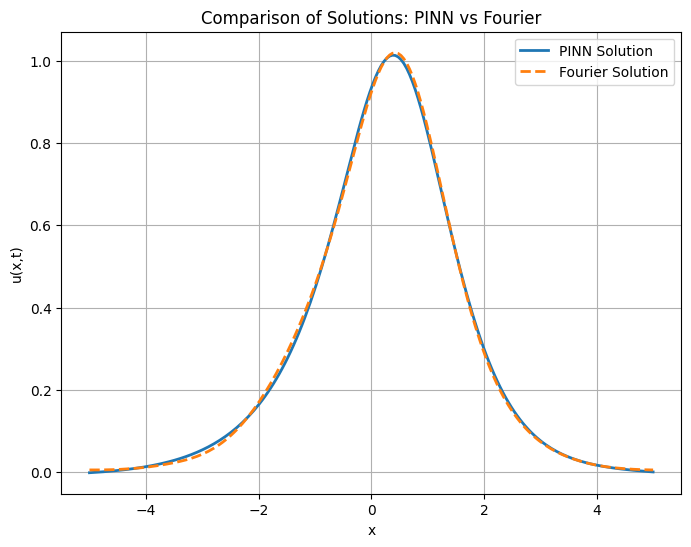

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import numpy as np

# Interpolar la solución de Fourier en los mismos puntos que la PINN
fourier_interp = interp1d(x, u_final, kind="cubic", fill_value="extrapolate")

# Evaluar la solución de Fourier en los mismos puntos de la PINN
u_fourier_interp = fourier_interp(x_np)

# Calcular métricas de error entre PINN y Fourier
mse = mean_squared_error(u_fourier_interp, u_pinn_np)  # Error cuadrático medio
l2_norm = np.linalg.norm(u_fourier_interp - u_pinn_np)  # Norma L2

# Mostrar los resultados
print(f"Comparación PINNs vs Fourier:")
print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Norma L2: {l2_norm:.6f}")

# Graficar la comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(x_np, u_pinn_np, label="PINN Solution", linestyle="-", linewidth=2)
plt.plot(x_np, u_fourier_interp, label="Fourier Solution", linestyle="--", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparison of Solutions: PINN vs Fourier")
plt.legend()
plt.grid(True)
plt.show()


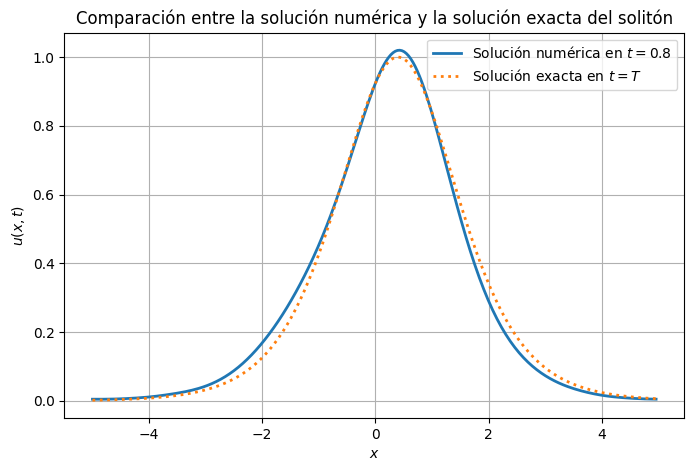

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
L = 10  # Longitud del dominio en x (de -5 a 5)
Nx = 256  # Número de puntos en x
dx = L / Nx  # Paso espacial
x = np.linspace(-5, 5, Nx, endpoint=False)  # Malla espacial

# Parámetros de tiempo
T = 0.8  # Tiempo total de simulación
dt = 1e-4  # Paso de tiempo
Nt = int(T / dt)  # Número de pasos de tiempo
beta = 0.1  # Coeficiente de dispersión

# Inicialización de la solución con la condición inicial
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Condición inicial u(x,0)

# Transformada de Fourier de la condición inicial
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias de Fourier
k3 = (1j * k) ** 3  # Derivada tercera en espacio de Fourier

# Método de Crank-Nicolson en espacio de Fourier
for _ in range(Nt):
    u = np.real(np.fft.ifft(u_hat))  # Transformada inversa para volver al espacio físico
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))  # No linealidad en espacio físico

    # Paso en espacio de Fourier usando Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)

# Solución final en espacio físico
u_final = np.real(np.fft.ifft(u_hat))

# Solución exacta del solitón
c = 1/2  # Velocidad del solitón
u_exact = 1.0 / np.cosh((x - c * T) / np.sqrt(2))**2  # Solución exacta en t = T

# Gráfica de la comparación
plt.figure(figsize=(8, 5))
#plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Condición inicial", linestyle="dashed")
plt.plot(x, u_final, label=f"Solución numérica en $t={T}$", linewidth=2)
plt.plot(x, u_exact, label="Solución exacta en $t=T$", linestyle="dotted", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Comparación entre la solución numérica y la solución exacta del solitón")
plt.legend()
plt.grid(True)
plt.show()


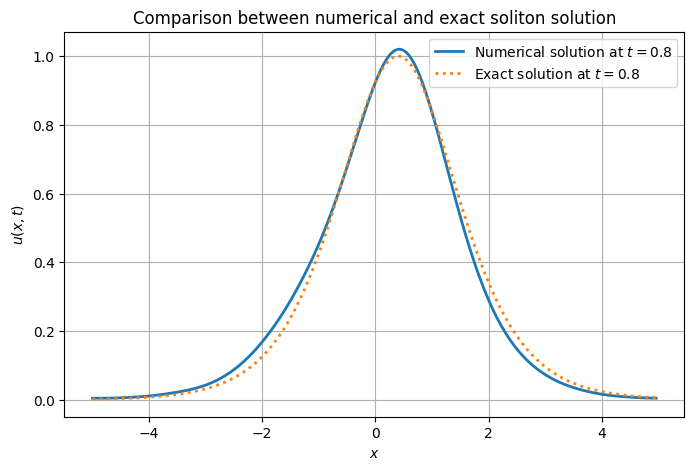

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Domain parameters
L = 10  # Domain length in x (from -5 to 5)
Nx = 256  # Number of points in x
dx = L / Nx  # Spatial step
x = np.linspace(-5, 5, Nx, endpoint=False)  # Spatial mesh

# Time parameters
T = 0.8  # Total simulation time
dt = 1e-4  # Time step
Nt = int(T / dt)  # Number of time steps
beta = 0.1  # Dispersion coefficient

# Solution initialization with the given initial condition
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Initial condition u(x,0)

# Fourier transform of the initial condition
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Fourier frequencies
k3 = (1j * k) ** 3  # Third derivative in Fourier space

# Crank-Nicolson method in Fourier space
for _ in range(Nt):
    u = np.real(np.fft.ifft(u_hat))  # Inverse Fourier transform to physical space
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))  # Nonlinearity in physical space

    # Step in Fourier space using Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)

# Final solution in physical space
u_final = np.real(np.fft.ifft(u_hat))

# Exact soliton solution
c = 1/2  # Soliton velocity
u_exact = 1.0 / np.cosh((x - c * T) / np.sqrt(2))**2  # Exact solution at t = T

# Plot the comparison
plt.figure(figsize=(8, 5))
#plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Initial condition", linestyle="dashed")
plt.plot(x, u_final, label=f"Numerical solution at $t={T}$", linewidth=2)
plt.plot(x, u_exact, label=f"Exact solution at $t={T}$", linestyle="dotted", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Comparison between numerical and exact soliton solution")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Compute error norms
error = u_final - u_exact
L2_error = np.sqrt(np.sum(error**2) * dx)
Linf_error = np.max(np.abs(error))

print(f"L2 error at t = {T}: {L2_error:.2e}")
print(f"Linf error at t = {T}: {Linf_error:.2e}")


L2 error at t = 0.8: 8.03e-02
Linf error at t = 0.8: 5.14e-02


L2 error vs fine solution: 5.77e-05
Linf error vs fine solution: 3.52e-05


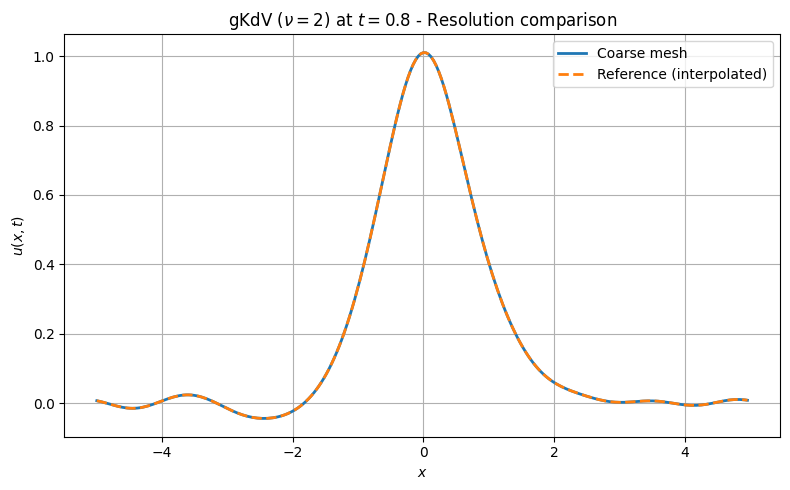

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def solve_gkdv(Nx, dt, T, nu=2, beta=0.1, xlim=5.0):
    L = 2 * xlim
    dx = L / Nx
    x = np.linspace(-xlim, xlim, Nx, endpoint=False)
    k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
    k3 = (1j * k)**3

    # Condición inicial: gaussiana
    u = np.exp(-x**2)
    u_hat = np.fft.fft(u)
    Nt = int(T / dt)

    for _ in range(Nt):
        u = np.real(np.fft.ifft(u_hat))
        ux = np.real(np.fft.ifft(1j * k * u_hat))
        nonlinear = u**nu * ux
        N_hat = np.fft.fft(nonlinear)
        u_hat = (u_hat - dt * N_hat) / (1 + beta * dt * k3)

    return x, np.real(np.fft.ifft(u_hat))

# Parámetros compartidos
T = 0.8
nu = 2
beta = 0.1

# Solución de referencia (alta resolución)
x_fine, u_fine = solve_gkdv(Nx=1024, dt=1e-5, T=T, nu=nu, beta=beta)

# Solución en malla más gruesa
x_coarse, u_coarse = solve_gkdv(Nx=256, dt=1e-4, T=T, nu=nu, beta=beta)

# Interpolar solución fina a la malla gruesa
interp_fine = interp1d(x_fine, u_fine, kind='cubic', fill_value="extrapolate")
u_ref_on_coarse = interp_fine(x_coarse)

# Cálculo de errores
dx = x_coarse[1] - x_coarse[0]
error = u_coarse - u_ref_on_coarse
L2 = np.sqrt(np.sum(error**2) * dx)
Linf = np.max(np.abs(error))

print(f"L2 error vs fine solution: {L2:.2e}")
print(f"Linf error vs fine solution: {Linf:.2e}")

# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(x_coarse, u_coarse, label="Coarse mesh", linewidth=2)
plt.plot(x_coarse, u_ref_on_coarse, '--', label="Reference (interpolated)", linewidth=2)
plt.title(f"gKdV ($\\nu = {nu}$) at $t = {T}$ - Resolution comparison")
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 1.72441e-01
Epoch 100, Loss: 1.42625e-02
Epoch 200, Loss: 3.62286e-03
Epoch 300, Loss: 1.13059e-03
Epoch 400, Loss: 5.23156e-04
Epoch 500, Loss: 3.11858e-04
Epoch 600, Loss: 2.35300e-04
Epoch 700, Loss: 1.95947e-04
Epoch 800, Loss: 1.70182e-04
Epoch 900, Loss: 1.51571e-04


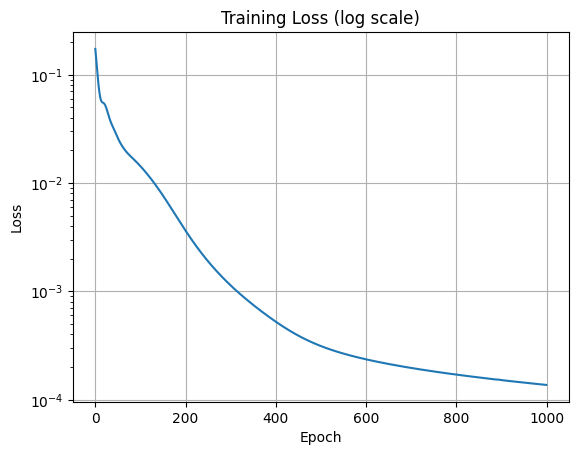

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)

# Define the domain
x_min, x_max = -5.0, 5.0
t_min, t_max = 0.0, 1.0

# Define the PINN architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

# Initial condition: u(x,0) = exp(-x^2)
def initial_condition(x):
    return torch.exp(-x**2)

# Generate training data
N_ic = 50
N_f = 1000

x_ic = torch.linspace(x_min, x_max, N_ic).view(-1, 1)
t_ic = torch.zeros_like(x_ic)
u_ic = initial_condition(x_ic)

x_f = torch.FloatTensor(N_f, 1).uniform_(x_min, x_max)
t_f = torch.FloatTensor(N_f, 1).uniform_(t_min, t_max)

x_ic.requires_grad = True
x_f.requires_grad = True
t_f.requires_grad = True

# Instantiate model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss function
mse = nn.MSELoss()

# Training loop
epochs = 1000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Initial condition loss
    u_pred_ic = model(x_ic, t_ic)
    loss_ic = mse(u_pred_ic, u_ic)

    # PDE residual loss
    x_f.requires_grad = True
    t_f.requires_grad = True
    u_pred_f = model(x_f, t_f)

    grads = torch.autograd.grad(u_pred_f, [x_f, t_f], grad_outputs=torch.ones_like(u_pred_f), create_graph=True)
    u_x = grads[0]
    u_t = grads[1]

    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x_f, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    f = u_t + (u_pred_f**2) * u_x + 0.1 * u_xxx
    loss_f = mse(f, torch.zeros_like(f))

    # Total loss
    loss = loss_ic + loss_f
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (log scale)')
plt.grid(True)
plt.show()


In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.2 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.407512 s

'compile' took 2.676224 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.88e-02, 3.23e-01]    [2.77e-02, 3.23e-01]    []  
1000      [3.91e-06, 9.84e-02]    [4.50e-06, 9.84e-02]    []  

Best model at step 1000:
  train loss: 9.84e-02
  test loss: 9.84e-02
  test metric: []

'train' took 14.012257 s



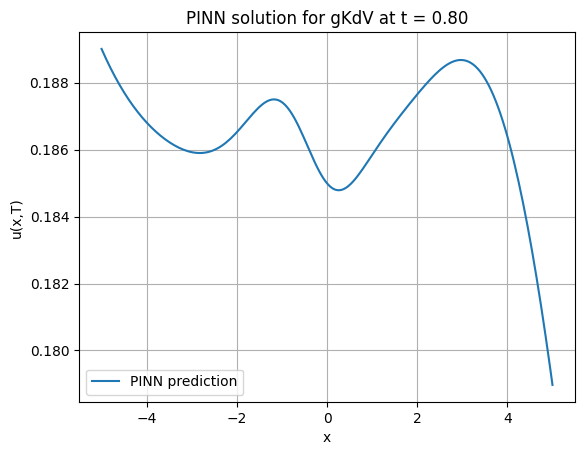

In [ ]:
import numpy as np
import deepxde as dde

# Parámetros del problema
beta = 0.1
nu = 2
L = 5.0
T = 0.8

# Ecuación gKdV: u_t + u^nu * u_x + beta * u_xxx = 0
def gkdv_pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    du_xxx = dde.grad.jacobian(du_xx, x, i=0, j=0)
    return du_t + u**nu * du_x + beta * du_xxx

# Condición inicial: gaussiana
def ic_func(x):
    return np.exp(-x[:, 0]**2)

# Geometría espacio-tiempo
geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Condición inicial
ic = dde.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

# Construir el dataset para entrenamiento
data = dde.data.TimePDE(
    geomtime,
    gkdv_pde,
    [ic],
    num_domain=1000,
    num_initial=50,
    num_boundary=0,
    solution=None,
    num_test=500,
)

# Red neuronal
net = dde.maps.FNN([2] + [32]*3 + [1], "tanh", "Glorot uniform")

# Modelo PINN
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=1000)

# Visualización: predicción en un tiempo fijo
import matplotlib.pyplot as plt

x = np.linspace(-L, L, 200)
t_fixed = T * np.ones_like(x)
X = np.stack((x, t_fixed), axis=1)
u_pred = model.predict(X)

plt.plot(x, u_pred, label="PINN prediction")
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.title("PINN solution for gKdV at t = {:.2f}".format(T))
plt.grid(True)
plt.legend()
plt.show()


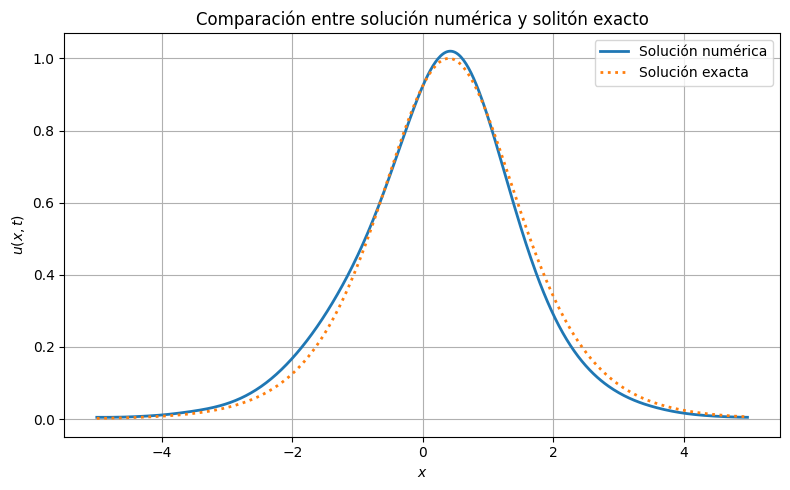

Error L2: 8.03e-02


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
L = 10  # Longitud del dominio
Nx = 512  # Más puntos para mayor resolución espacial
dx = L / Nx
x = np.linspace(-L/2, L/2, Nx, endpoint=False)

# Parámetros de tiempo
T = 0.8
dt = 5e-5  # Paso más pequeño
Nt = int(T / dt)
beta = 0.1  # Coeficiente de dispersión

# Condición inicial
u = 1.0 / np.cosh(x / np.sqrt(2))**2

# Transformada de Fourier
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
k1 = 1j * k
k3 = (1j * k) ** 3

# Filtro de dealiasing (2/3-rule)
k_cut = int(Nx/3)
filter_mask = np.abs(k) < (k_cut * 2 * np.pi / L)

# Avance temporal (Crank-Nicolson + dealiasing)
for _ in range(Nt):
    u = np.real(np.fft.ifft(u_hat))
    ux = np.real(np.fft.ifft(k1 * u_hat))
    nonlinear = u * ux

    # Fourier transform of nonlinear term and filter
    nonlinear_hat = np.fft.fft(nonlinear)
    nonlinear_hat *= filter_mask  # Dealiasing

    # Crank-Nicolson step in Fourier space
    u_hat = (u_hat - dt * nonlinear_hat) / (1 + beta * dt * k3)

# Solución numérica final
u_final = np.real(np.fft.ifft(u_hat))

# Solución exacta
c = 1/2
u_exact = 1.0 / np.cosh((x - c * T) / np.sqrt(2))**2

# Comparación
plt.figure(figsize=(8, 5))
plt.plot(x, u_final, label="Solución numérica", linewidth=2)
plt.plot(x, u_exact, label="Solución exacta", linestyle="dotted", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Comparación entre solución numérica y solitón exacto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Error L2
error_L2 = np.linalg.norm(u_final - u_exact) * np.sqrt(dx)
print(f"Error L2: {error_L2:.2e}")


Epoch 500, Loss: 0.003134
Epoch 1000, Loss: 0.001222


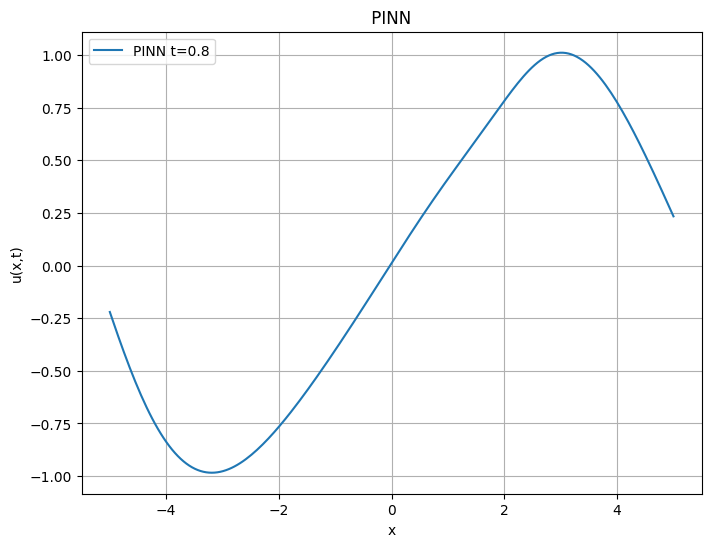

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = torch.sin(np.pi * x_vals / 5.0)  # si tu L=5
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [ 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.000158
Epoch 1000, Loss: 0.000078


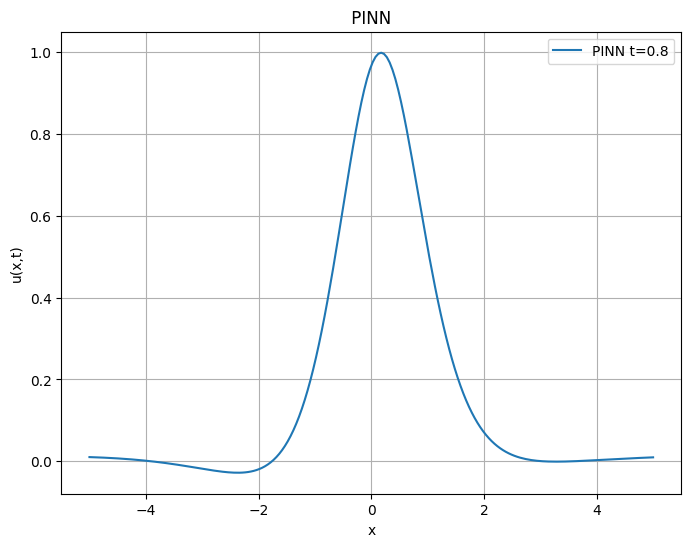

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = torch.exp(-x_vals**2)  # un pulso gaussiano
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [ 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.010158
Epoch 1000, Loss: 0.009008


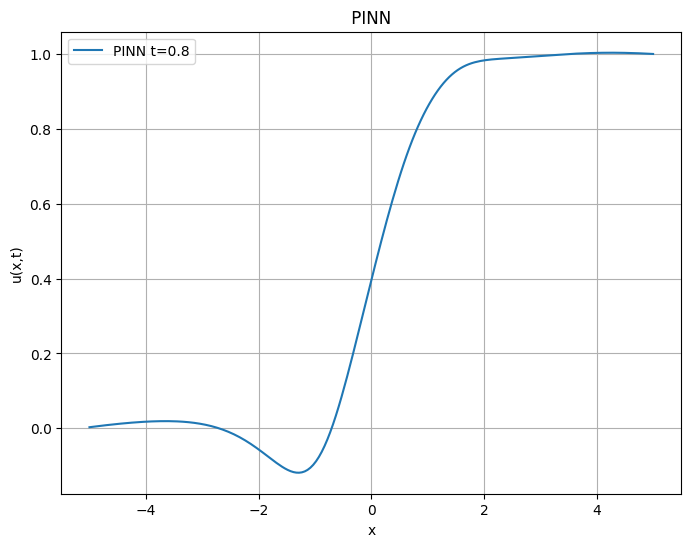

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 * (x_vals > 0).float()  # 1 para x>0, 0 para x<=0
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [ 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.009122
Epoch 1000, Loss: 0.007436


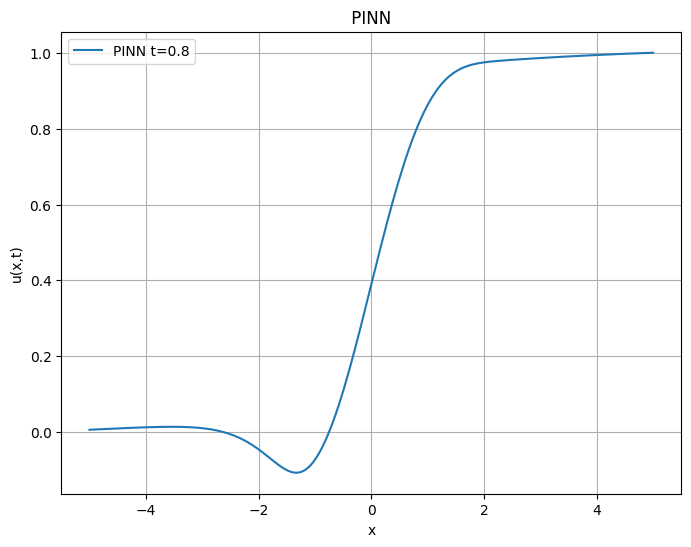

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 * (x_vals > 0).float()  # 1 para x>0, 0 para x<=0
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 2.0 * torch.rand(N_colloc, 1)  # t ∈ [0, 2]


# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [ 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.008389
Epoch 1000, Loss: 0.004620


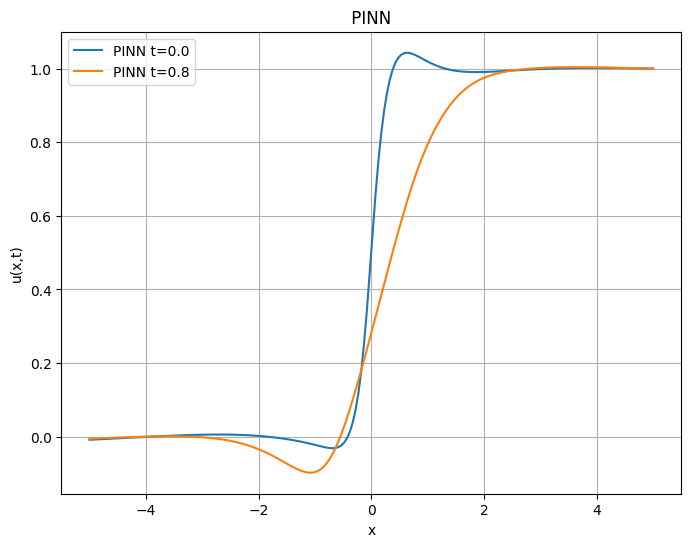

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 * (x_vals > 0).float()  # 1 para x>0, 0 para x<=0
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -10.0 + 20.0 * torch.rand(N_colloc, 1)
x_vals = torch.linspace(-10, 10, N0).reshape(-1,1)



# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.000896
Epoch 1000, Loss: 0.000562
Epoch 1500, Loss: 0.000173
Epoch 2000, Loss: 0.000115


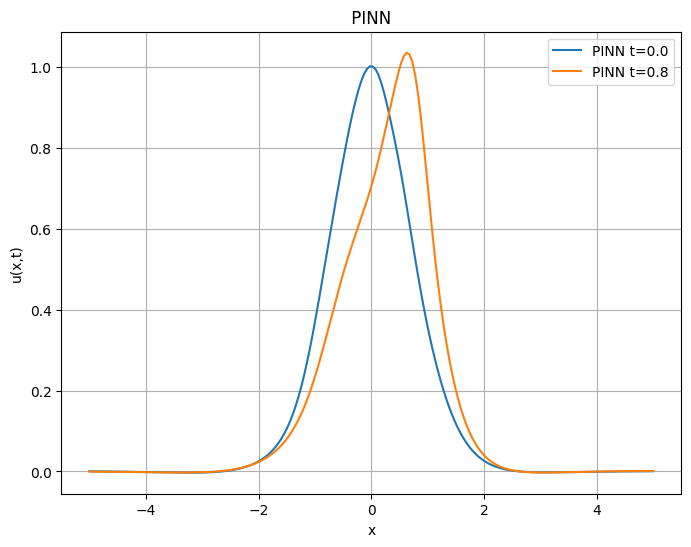

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    epsilon = 0.01  # <--- Cambiamos aquí
    # Ecuación: u_t + u*u_x + epsilon*u_xxx = 0
    return u_t + u*u_x + epsilon*u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# 2) Cambiamos la condición inicial a un pulso gaussiano
N0 = 50
x_vals = torch.linspace(-10, 10, N0).reshape(-1, 1)
u_vals = torch.exp(-x_vals**2)  # Gauss
x0 = x_vals.detach()
u0 = u_vals.detach()

# Cambiamos los puntos de colisión (domin. de x y t)
N_colloc = 1000
# x ∈ [-10, 10]
x_colloc = -10.0 + 20.0 * torch.rand(N_colloc, 1)
x_vals = torch.linspace(-10, 10, N0).reshape(-1,1)
# t ∈ [0, 2]
t_colloc = 2.0 * torch.rand(N_colloc, 1)



# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 4) Aumentamos épocas
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.000807
Epoch 1000, Loss: 0.000613
Epoch 1500, Loss: 0.000399
Epoch 2000, Loss: 0.000260


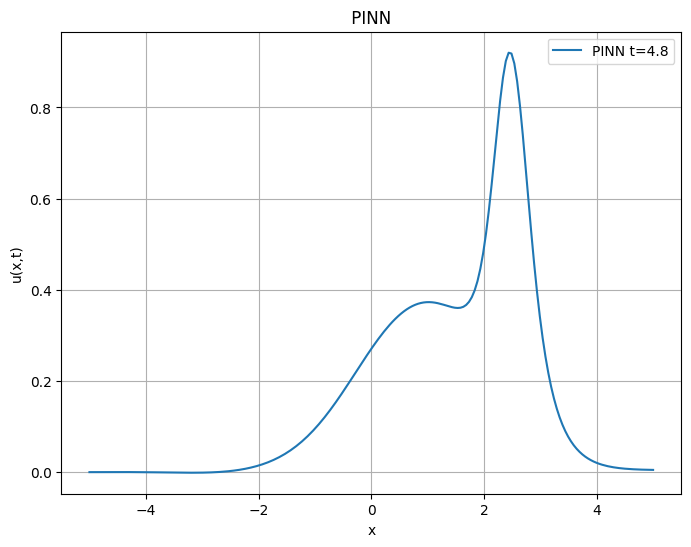

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    epsilon = 0.01  # <--- Cambiamos aquí
    # Ecuación: u_t + u*u_x + epsilon*u_xxx = 0
    return u_t + u*u_x + epsilon*u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# 2) Cambiamos la condición inicial a un pulso gaussiano
N0 = 50
x_vals = torch.linspace(-10, 10, N0).reshape(-1, 1)
u_vals = torch.exp(-x_vals**2)  # Gauss
x0 = x_vals.detach()
u0 = u_vals.detach()

# Cambiamos los puntos de colisión (domin. de x y t)
N_colloc = 1000
# x ∈ [-10, 10]
x_colloc = -10.0 + 20.0 * torch.rand(N_colloc, 1)
x_vals = torch.linspace(-10, 10, N0).reshape(-1,1)
# t ∈ [0, 5]
t_colloc = 5.0 * torch.rand(N_colloc, 1)



# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# 4) Aumentamos épocas
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [ 4.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.012762
Epoch 1000, Loss: 0.004167


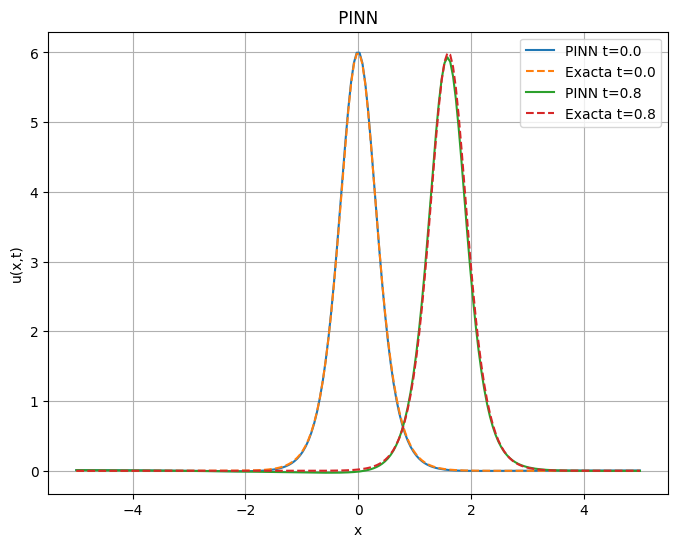

Error relativo L2 (t = 0.8): 0.0297


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

def kdv_exact_soliton(x, t, c=2):
    return 3*c / np.cosh(0.5 * np.sqrt(c/0.1) * (x - c*t))**2


# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals_clean = 6.0 / torch.cosh(x_vals/np.sqrt(2*0.1))**2

# Añadir ruido gaussiano a la condición inicial (ruido ~ N(0, sigma^2))
noise_level = 0.05  # 5% de ruido, puedes ajustar
torch.manual_seed(42)
noise = noise_level * torch.randn_like(u_vals_clean)
u_vals_noisy = u_vals_clean + noise

x0 = x_vals.detach()
u0 = u_vals_noisy.detach()
#x0 = x_vals.detach()
#u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')


plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()
# Error L2 relativo para t = 0.8
error_l2 = np.linalg.norm(u_pinn_np - u_exact_np, 2) / np.linalg.norm(u_exact_np, 2)
print(f"Error relativo L2 (t = {t}): {error_l2:.4f}")



Epoch 50, Loss: 0.010748
Epoch 100, Loss: 0.003037
Epoch 150, Loss: 0.001075
Epoch 200, Loss: 0.000472
Epoch 250, Loss: 0.000303
Epoch 300, Loss: 0.000237
Epoch 350, Loss: 0.000196
Epoch 400, Loss: 0.000164
Epoch 450, Loss: 0.000137
Epoch 500, Loss: 0.000115


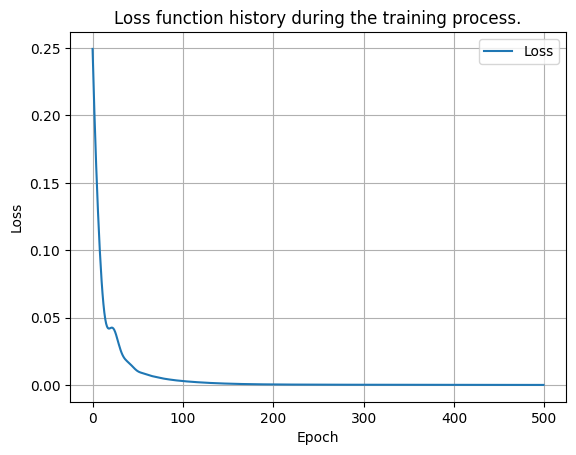

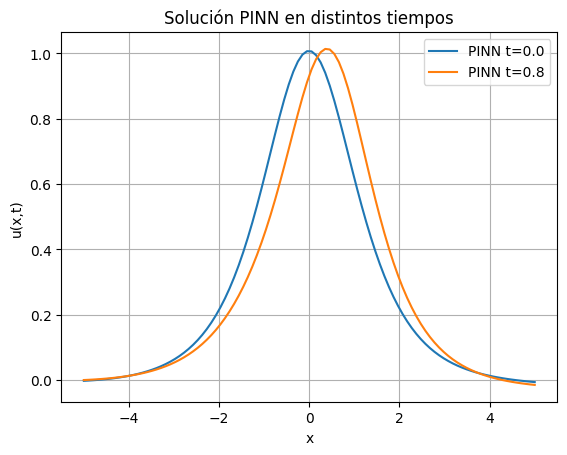

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Definición de la arquitectura de la PINN
# ------------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        """layers es una lista de enteros, por ejemplo [2, 32, 32, 1].
           El primer 2 corresponde a (x, t). El último 1 corresponde a u(x,t).
        """
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        # Concatenamos x y t
        X = torch.cat((x, t), dim=1)
        # Activación tanh en todas excepto la última
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        return self.hidden_layers[-1](X)

# ------------------------------
# 2. PDE: u_t + u u_x + 0.1 u_xxx = 0
# ------------------------------
def pde_residual(x, t, model):
    # Hacemos .clone() + requires_grad_(True) en las entradas
    x_ = x.clone().detach().requires_grad_(True)
    t_ = t.clone().detach().requires_grad_(True)

    u = model(x_, t_)
    u_t = torch.autograd.grad(u, t_, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x_, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + u * u_x + 0.1 * u_xxx

# ------------------------------
# 3. Función de pérdida sencilla (sin pesos adaptativos para simplificar)
# ------------------------------
def loss_function(model, x0, u0, x_colloc, t_colloc):
    # 1) Condición inicial
    x0_ = x0.clone().detach()
    pred_u0 = model(x0_, torch.zeros_like(x0_))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    # 2) Residuo PDE
    x_colloc_ = x_colloc.clone().detach().requires_grad_(True)
    t_colloc_ = t_colloc.clone().detach().requires_grad_(True)
    res = pde_residual(x_colloc_, t_colloc_, model)
    mse_pde = torch.mean(res**2)

    return mse_ic + mse_pde

# ------------------------------
# 4. Construcción del modelo y datos
# ------------------------------
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Condición inicial: solitón tipo sech^2
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals / np.sqrt(2))**2
x0 = x_vals.clone().detach()
u0 = u_vals.clone().detach()

# Puntos de colisión
N_colloc = 500  # <-- se reducen para evitar problemas de memoria
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# ------------------------------
# 5. Entrenamiento
# ------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 500
loss_history = []

for epoch in range(1, epochs+1):
    loss_val = loss_function(model, x0, u0, x_colloc, t_colloc)
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    loss_history.append(loss_val.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss_val.item():.6f}")

# ------------------------------
# 6. Graficar la historia de pérdida
# ------------------------------
plt.figure()
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function history during the training process.")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 7. Evaluación en distintos tiempos
# ------------------------------
model.eval()
times_to_plot = [0.0, 0.8]
x_min, x_max = -5, 5
Nx = 100
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

plt.figure()
for t in times_to_plot:
    t_ = torch.full_like(x_plot, t)
    with torch.no_grad():
        u_pinn = model(x_plot, t_)
    plt.plot(x_plot.numpy(), u_pinn.numpy(), label=f"PINN t={t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Solución PINN en distintos tiempos")
plt.legend()
plt.grid(True)
plt.show()


Training Small net, 500 points...
Training Medium net, 1000 points...
Training Large net, 1500 points...


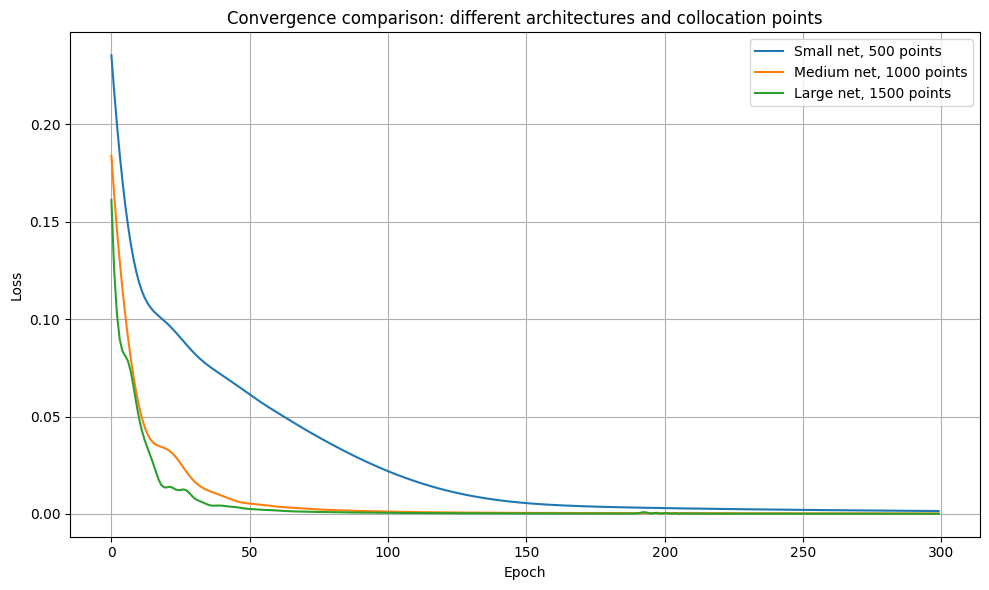

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Generalized PINN architecture
# ------------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        return self.hidden_layers[-1](X)

# ------------------------------
# PDE residual: u_t + u u_x + 0.1 u_xxx = 0
# ------------------------------
def pde_residual(x, t, model):
    x_ = x.clone().detach().requires_grad_(True)
    t_ = t.clone().detach().requires_grad_(True)
    u = model(x_, t_)
    u_t = torch.autograd.grad(u, t_, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x_, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]
    return u_t + u * u_x + 0.1 * u_xxx

# ------------------------------
# Loss function
# ------------------------------
def loss_function(model, x0, u0, x_colloc, t_colloc):
    x0_ = x0.clone().detach()
    pred_u0 = model(x0_, torch.zeros_like(x0_))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    x_colloc_ = x_colloc.clone().detach().requires_grad_(True)
    t_colloc_ = t_colloc.clone().detach().requires_grad_(True)
    res = pde_residual(x_colloc_, t_colloc_, model)
    mse_pde = torch.mean(res**2)

    return mse_ic + mse_pde

# ------------------------------
# Training loop
# ------------------------------
def train_pinn(layers, N_colloc, epochs=300):
    model = PINN(layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Initial condition: sech^2 soliton
    N0 = 50
    x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
    u_vals = 1.0 / torch.cosh(x_vals / np.sqrt(2))**2
    x0 = x_vals.clone().detach()
    u0 = u_vals.clone().detach()

    # Collocation points
    x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
    t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

    loss_history = []
    for epoch in range(epochs):
        loss_val = loss_function(model, x0, u0, x_colloc, t_colloc)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_history.append(loss_val.item())

    return loss_history

# ------------------------------
# Experiments with different architectures and collocation points
# ------------------------------
experiments = [
    {"name": "Small net, 500 points", "layers": [2, 16, 16, 1], "N_colloc": 500},
    {"name": "Medium net, 1000 points", "layers": [2, 32, 32, 32, 1], "N_colloc": 1000},
    {"name": "Large net, 1500 points", "layers": [2, 64, 64, 64, 64, 1], "N_colloc": 1500}
]

results = {}

for exp in experiments:
    print(f"Training {exp['name']}...")
    history = train_pinn(exp["layers"], exp["N_colloc"])
    results[exp["name"]] = history

# ------------------------------
# Plotting the loss histories
# ------------------------------
plt.figure(figsize=(10,6))
for name, history in results.items():
    plt.plot(history, label=name)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence comparison: different architectures and collocation points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0 Loss 0.395826
Epoch 100 Loss 0.255449
Epoch 200 Loss 0.192309
Epoch 300 Loss 0.145762
Epoch 400 Loss 0.135321
Epoch 500 Loss 0.129289
Epoch 600 Loss 0.122043
Epoch 700 Loss 0.116002
Epoch 800 Loss 0.110497
Epoch 900 Loss 0.105415


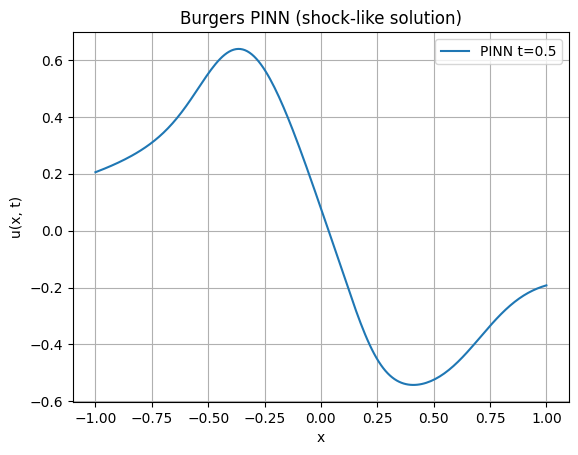

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Viscosidad baja
nu = 0.01 / np.pi

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.layers[:-1]:
            X = torch.tanh(layer(X))
        return self.layers[-1](X)

def residual_burgers(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx

def loss(model, x0, u0, x_f, t_f):
    pred_u0 = model(x0, torch.zeros_like(x0))
    ic_loss = torch.mean((pred_u0 - u0) ** 2)
    res = residual_burgers(x_f, t_f, model)
    pde_loss = torch.mean(res**2)
    return ic_loss + pde_loss

# Inicialización
layers = [2, 20, 20, 1]
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Condición inicial
N0 = 100
x0 = torch.linspace(-1, 1, N0).reshape(-1, 1)
u0 = -torch.sin(np.pi * x0)

# Collocation points
Nf = 500
x_f = -1 + 2 * torch.rand(Nf, 1)
t_f = torch.rand(Nf, 1)

# Entrenamiento
for epoch in range(1000):
    optimizer.zero_grad()
    l = loss(model, x0, u0, x_f, t_f)
    l.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {l.item():.6f}")

# Evaluar solución en t = 0.5
x_test = torch.linspace(-1, 1, 200).reshape(-1, 1)
t_test = 0.5 * torch.ones_like(x_test)
with torch.no_grad():
    u_pred = model(x_test, t_test)

# Gráfica
plt.plot(x_test.numpy(), u_pred.numpy(), label="PINN t=0.5")
plt.title("Burgers PINN (shock-like solution)")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.grid()
plt.legend()
plt.show()


Epoch 500, Loss: 0.022937
Epoch 1000, Loss: 0.001908


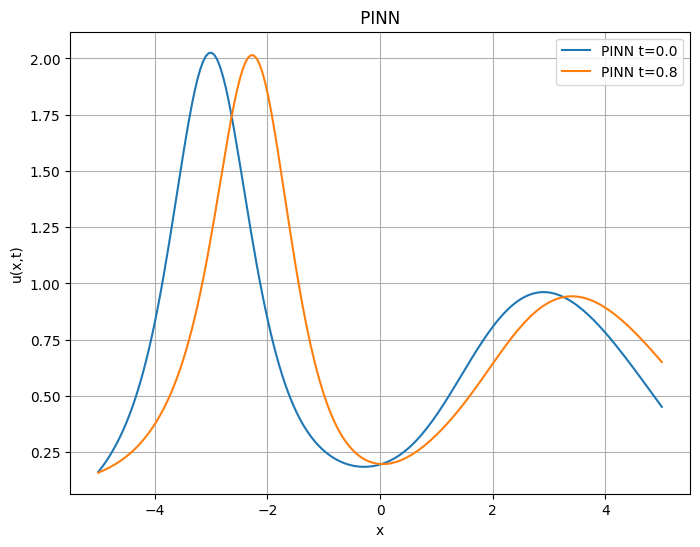

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
def initial_condition_torch(x):
    A1, B1, x1 = 2.0, 1.0, -3.0
    A2, B2, x2 = 1.0, 0.5, 3.0
    return A1 * torch.cosh(B1 * (x - x1)).reciprocal()**2 + \
           A2 * torch.cosh(B2 * (x - x2)).reciprocal()**2


# Crear condición inicial en puntos fijos
# Crear condición inicial en puntos fijos
N0 = 100
x0_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u0_vals = initial_condition_torch(x0_vals)

x0 = x0_vals.clone().detach()
u0 = u0_vals.clone().detach()




# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.5 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.075284 s

'compile' took 1.545228 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.12e-01, 6.61e-02, 3.74e+00]    [2.12e-01, 6.61e-02, 3.74e+00]    []  
1000      [1.49e-02, 2.70e-01, 9.05e-02]    [1.49e-02, 2.70e-01, 9.05e-02]    []  

Best model at step 1000:
  train loss: 3.75e-01
  test loss: 3.75e-01
  test metric: []

'train' took 43.253199 s



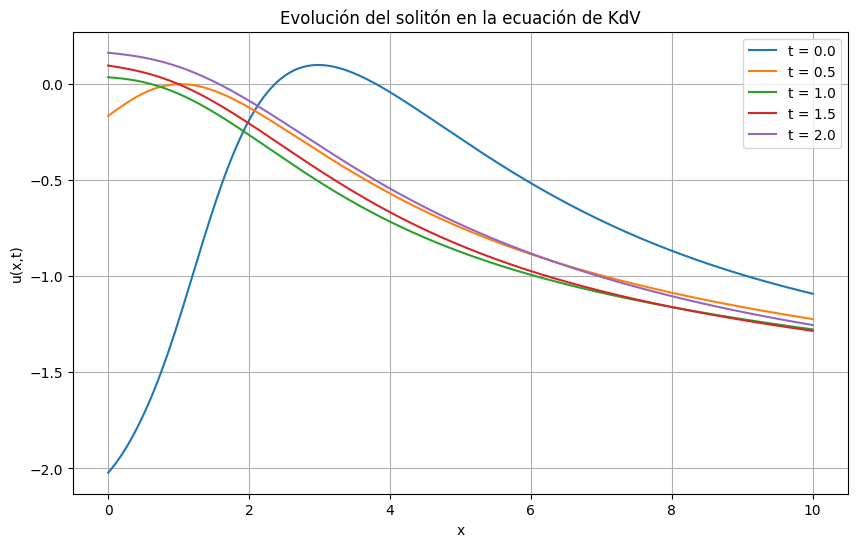

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

# Dominio espacial y temporal
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Parámetros KdV
a = 6.0  # No linealidad
b = 1.0  # Dispersión

# Término dispersivo con diferencias finitas (Ej: u_{xxx})
def dispersive_term(u, x):
    u_xxx = dde.grad.hessian(u, x, i=0, j=0, component=0)
    return b * u_xxx

# Definir PDE residual: u_t + a u u_x + b u_{xxx} = 0
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_xxx = dde.grad.hessian(u_x, x, i=0, j=0)
    return u_t + a * u * u_x + b * u_xxx

# Condición inicial (ejemplo: solitón)
def initial(x):
    return -2 * (1 / np.cosh(x[:, 0] - 0.5))**2

# Condiciones de frontera tipo Dirichlet (puedes ajustar)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary)

# Condición inicial
ic = dde.IC(geomtime, initial, lambda x, on_initial: on_initial)

# Armar dataset
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2000, num_boundary=100, num_initial=100)

# Arquitectura de red neuronal
net = dde.maps.FNN([2] + [50]*3 + [1], "tanh", "Glorot normal")

# Modelo
model = dde.Model(data, net)

# Entrenamiento
model.compile("adam", lr=1e-3)
model.train(epochs=1000)

# Solución final
x = np.linspace(0, L, 200)
t_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
plt.figure(figsize=(10, 6))
for t in t_vals:
    xt = np.stack([x, t * np.ones_like(x)], axis=1)
    u = model.predict(xt).flatten()
    plt.plot(x, u, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Evolución del solitón en la ecuación de KdV")
plt.grid(True)
plt.show()



In [ ]:
# Tercera derivada por diferencias finitas centradas
def finite_diff_third_derivative(model, x, t, h=0.01):
    x_plus1 = x + h
    x_minus1 = x - h
    x_plus2 = x + 2*h
    x_minus2 = x - 2*h

    with torch.no_grad():
        u_p2 = model(x_plus2, t)
        u_p1 = model(x_plus1, t)
        u_m1 = model(x_minus1, t)
        u_m2 = model(x_minus2, t)

    return (-u_p2 + 2*u_p1 - 2*u_m1 + u_m2) / (2 * h**3)


In [ ]:
# PDE con u_t + u u_x + 0.1 u_xxx ≈ 0
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Parte dispersiva híbrida
    u_xxx_fd = finite_diff_third_derivative(model, x.detach(), t.detach())  # <- NO requiere gradientes

    return u_t + u * u_x + 0.1 * u_xxx_fd


In [ ]:
def kdv_exact_soliton(x, t):
    z = 0.5 * (x - 2 * t)
    return 0.5 * (1 / np.cosh(z))**2
